In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
palette = sns.color_palette("Spectral", n_colors=13) 
sns.set_theme(context='notebook', palette=palette, style='darkgrid')
rs = 58

In [68]:
#loading the data set
filepath="./data.csv"
data=pd.read_csv(filepath)

In [69]:
#displaying the first 5 rows of the data set
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [70]:
#getting the dimension of the data
print("The dimension of the data set is: (Rows , Column) ", data.shape , "\n")
#column names and data types
print("The column names and data types are:\n",data.dtypes)

The dimension of the data set is: (Rows , Column)  (891, 12) 

The column names and data types are:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


### Based on the above discription 
1. Name can be dropped : See no point of having name as a feature
2. PassengerId can be dropepd or retained but should not be used in traing at all
3. Sex : needs to be encoded M - 0 F - 1
4. Ticket : need to understand how ticket can be used
5. Cabin : need to understand how cabin can be used
6. Embarked needs to be encoded C = Cherbourg - 0  , Q = Queenstown - 1 , S = Southhampton - 2

In [71]:
#checking for duplicates
print("Number of duplicates in the data set: ", data.duplicated().sum())

Number of duplicates in the data set:  0


In [72]:
#checking for missing values
print("Total number of missing values in the data set:\n\n", data.isnull().sum())

Total number of missing values in the data set:

 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [73]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Data imputation based on the above outputs
1. Age is a valid integer number :  can find the distribution pattern and then do data imputation 
2. Cabin has too many missing value ~ 77% can not be imputed or will cause false positive and wrong decisions (will drop)
3. Embarked is fairly negligible can use the mean of the data to impute

<AxesSubplot:title={'center':'Visualizing Missing Values'}>

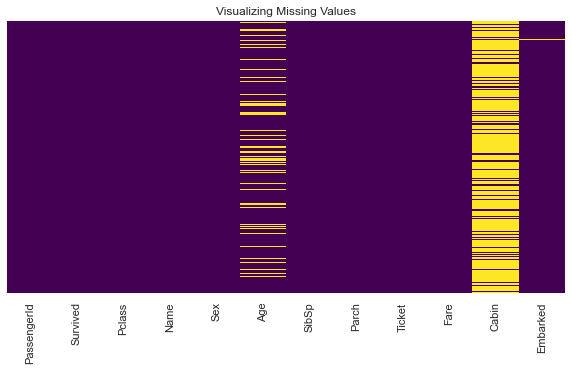

In [74]:
plt.figure(figsize=(10, 5))
plt.title("Visualizing Missing Values")
sns.heatmap(data.isnull(), cbar=False, cmap="viridis", yticklabels=False)

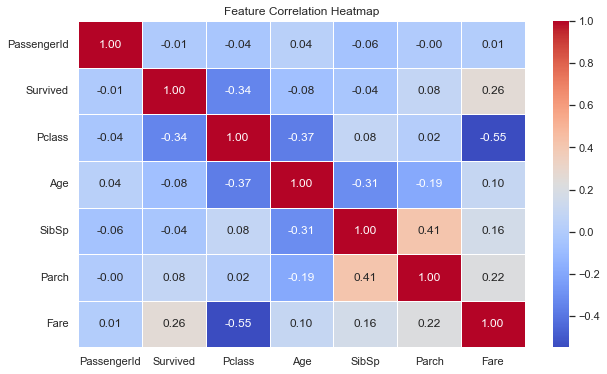

In [75]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### not much infor missing a lot of data and the categorical data as well

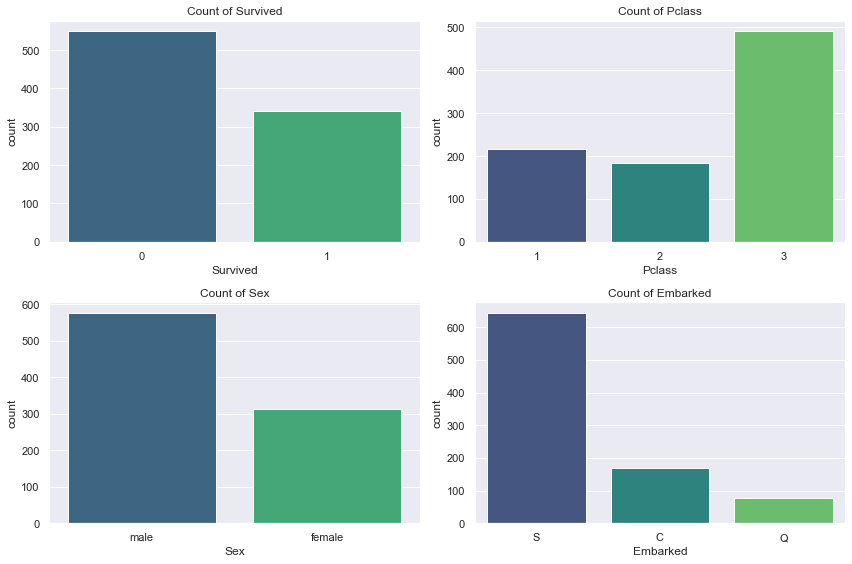

In [76]:
# Define numerical and categorical features separately
num_features = ["Age", "Fare", "SibSp", "Parch"]
cat_features = ["Survived", "Pclass", "Sex", "Embarked"]

# # Plot histograms for numerical features
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# axes = axes.flatten()

# for i, col in enumerate(num_features):
#     sns.histplot(data[col], bins=30, kde=True, ax=axes[i], color="blue")
#     axes[i].set_title(f"Distribution of {col}")

# plt.tight_layout()
# plt.show()

# Plot bar charts for categorical features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    sns.countplot(x=data[col], palette="viridis", ax=axes[i])
    axes[i].set_title(f"Count of {col}")

plt.tight_layout()
plt.show()


#### Distribution and changes
Age is skewed need some correction, need to remove outliers
Fare is very skewed need some transformation



In [77]:
## feature engineering and data 
#checking the cabin data
data["Cabin"].value_counts()
# Checking unique values and missing data in Cabin
unique_cabins =data["Cabin"].nunique()
missing_cabins = data["Cabin"].isna().sum()
unique_cabins, missing_cabins

(147, 687)

(Cabin
 False    0.299854
 True     0.666667
 Name: Survived, dtype: float64,
 <AxesSubplot:title={'center':'Survival Rate by Cabin Availability'}, xlabel='Cabin'>)

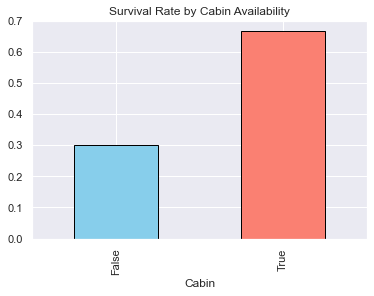

In [78]:
# cabin vs survival
cabin_survival = data.groupby(data["Cabin"].notna())["Survived"].mean()
cabin_survival , cabin_survival.plot(kind="bar", color=["skyblue", "salmon"], edgecolor="black", title="Survival Rate by Cabin Availability")

having a cabin means having a shot at survival ? or atleast survived to tell the cabin

<AxesSubplot:title={'center':'Survival Rate by Cabin Letter'}, xlabel='Cabin_Letter'>

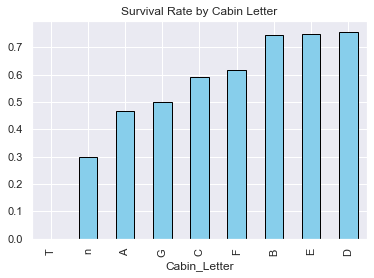

In [79]:
# Extracting the first letter of the cabin (e.g., 'C85' → 'C')
data["Cabin_Letter"] = data["Cabin"].astype(str).str[0]

# Checking survival rate by Cabin Letter
cabin_letter_survival = data.groupby("Cabin_Letter")["Survived"].mean().sort_values()

cabin_letter_survival
cabin_letter_survival.plot(kind="bar", color="skyblue", edgecolor="black", title="Survival Rate by Cabin Letter")

cabin B,E,D had higher chances of survival, rest were decent

In [80]:
#check sparseness of cabin column
data.Cabin.isna().sum() 

687

too much missing data! can't impute and useless to check the letter availability , cab use binary encoding to create new feature hasCabin 1-> yes, 0-> false, can link survivability with that

In [81]:
# Create binary HasCabin feature (1 if cabin exists, 0 if missing)
data["HasCabin"] = data["Cabin"].notna().astype(int)

data[["Cabin", "HasCabin"]].head(10)


,Cabin,HasCabin
0,NaN,0
1,C85,1
2,NaN,0
3,C123,1
4,NaN,0
5,NaN,0
6,E46,1
7,NaN,0
8,NaN,0
9,NaN,0


In [82]:
#ticket column analysis
data.Ticket.isna().sum()

0

everyone had a ticket!

In [83]:
print("Total number of unique tickets: ", data["Ticket"].nunique())
print("Total count of tickets: ", data["Ticket"].count())
#shared tickets ?
print("Number of shared tickets: ", data["Ticket"].duplicated().sum())
#tickets that are shared
shared_tickets = data["Ticket"].duplicated(keep=False)


Total number of unique tickets:  681
Total count of tickets:  891
Number of shared tickets:  210


In [84]:
# Extracting ticket prefixes (non-numeric parts before space, if any)
data["Ticket_Prefix"] = data["Ticket"].apply(lambda x: x.split()[0] if not x.isdigit() else "None")

# Counting occurrences of each prefix
ticket_prefix_counts = data["Ticket_Prefix"].value_counts()

# Checking survival rate by Ticket Prefix
ticket_prefix_survival = data.groupby("Ticket_Prefix")["Survived"].mean().sort_values()

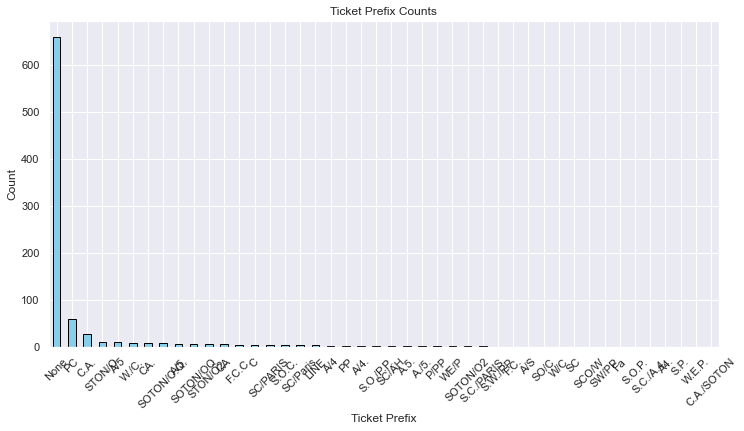

In [85]:
# Plot the Ticket Prefix Counts with increased figure size
plt.figure(figsize=(12, 6))
ticket_prefix_counts.plot(kind="bar", color="skyblue", edgecolor="black", title="Ticket Prefix Counts")
plt.xlabel("Ticket Prefix")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


<AxesSubplot:title={'center':'Survival Rate by Ticket Prefix'}, xlabel='Ticket_Prefix'>

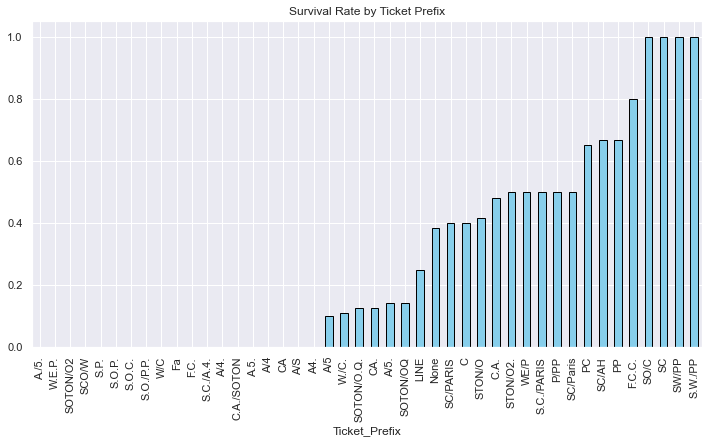

In [86]:
# Plot the Ticket Prefix Survival Rates
plt.figure(figsize=(12, 6))
ticket_prefix_survival.plot(kind="bar", color="skyblue", edgecolor="black", title="Survival Rate by Ticket Prefix")

some tickets had better chances of survival

In [87]:
# Create 'HasGroupTicket' feature (1 if duplicate ticket, 0 if unique)
data["HasGroupTicket"] = data["Ticket"].duplicated(keep=False).astype(int)

# Simplify rare ticket prefixes (group those with fewer than 10 occurrences into "Other")
rare_prefixes = ticket_prefix_counts[ticket_prefix_counts < 10].index
data["Ticket_Prefix"] = data["Ticket_Prefix"].apply(lambda x: "Other" if x in rare_prefixes else x)


data[["Ticket", "Ticket_Prefix", "HasGroupTicket"]].head(10)


,Ticket,Ticket_Prefix,HasGroupTicket
0,A/5 21171,A/5,0
1,PC 17599,PC,0
2,STON/O2. 3101282,Other,0
3,113803,None,1
4,373450,None,0
5,330877,None,0
6,17463,None,0
7,349909,None,1
8,347742,None,1
9,237736,None,1


In [88]:
# Create the FamilySize feature (SibSp + Parch + 1)
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1

# Create the IsAlone feature (1 if FamilySize == 1, else 0)
data["IsAlone"] = (data["FamilySize"] == 1).astype(int)

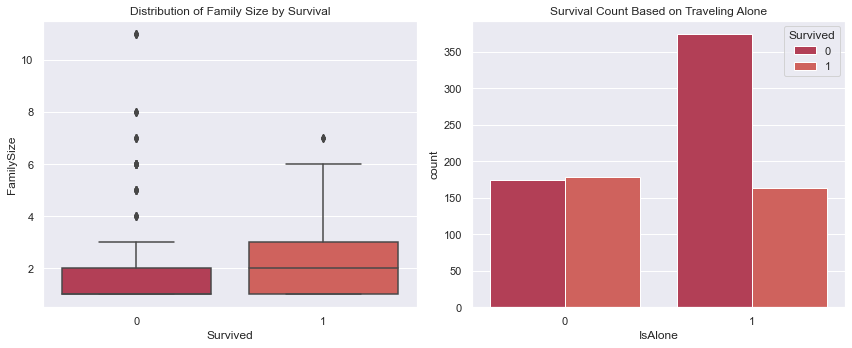

In [89]:
# Set up the plotting area
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot FamilySize vs Survived
sns.boxplot(x="Survived", y="FamilySize", data=data, ax=axes[0])
axes[0].set_title("Distribution of Family Size by Survival")

# Plot IsAlone vs Survived
sns.countplot(x="IsAlone", hue="Survived", data=data, ax=axes[1])
axes[1].set_title("Survival Count Based on Traveling Alone")

# Show plots
plt.tight_layout()
plt.show()

# Missing Values

In [90]:
# Find columns with missing values and their counts
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter only columns with missing values

missing_values


Age         177
Cabin       687
Embarked      2
dtype: int64

<AxesSubplot:title={'center':'Visualizing Missing Values'}>

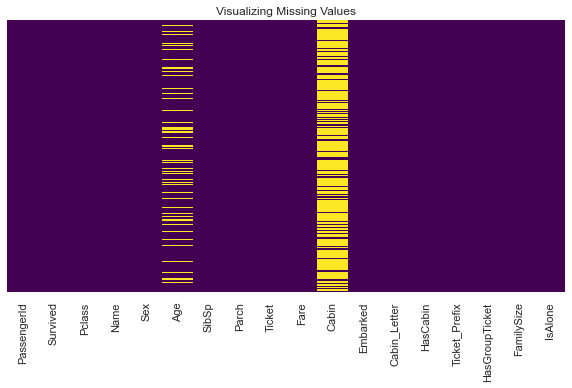

In [91]:
#visualize the missing values
plt.figure(figsize=(10, 5))
plt.title("Visualizing Missing Values")
sns.heatmap(data.isnull(), cbar=False, cmap="viridis", yticklabels=False)

cabin itself if of no use, we have feature based on it hasCabin and cabin letter can drop cabin and cabin letter has too many missing values, will only use HasCabin

In [92]:
#drop cabin and cabin letter columns
data.drop(["Cabin", "Cabin_Letter"], axis=1, inplace=True)

<AxesSubplot:title={'center':'Visualizing Missing Values'}>

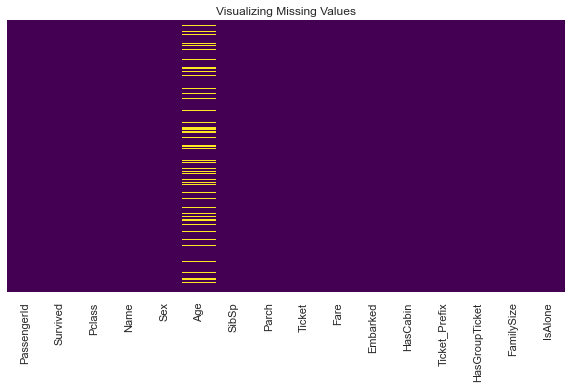

In [93]:
plt.figure(figsize=(10, 5))
plt.title("Visualizing Missing Values")
sns.heatmap(data.isnull(), cbar=False, cmap="viridis", yticklabels=False)

In [94]:
#check the missing values again
data.isnull().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age               177
SibSp               0
Parch               0
Ticket              0
Fare                0
Embarked            2
HasCabin            0
Ticket_Prefix       0
HasGroupTicket      0
FamilySize          0
IsAlone             0
dtype: int64

embarked has very low data missing can drop the two missing records

In [95]:
#drop the rows with missing values on embarked column
data.dropna(subset=["Embarked"], inplace=True)

In [96]:
data.isnull().sum()
print("The dimension of the data set is: (Rows , Column) ", data.shape , "\n")

The dimension of the data set is: (Rows , Column)  (889, 16) 



understanding age

In [97]:
print("Total available data for age: ", data.Age.count())
print("total missing data for age: ", data.Age.isna().sum())

Total available data for age:  712
total missing data for age:  177


what to use ? mean or median ? visualizing for data imputation

Text(0.5, 1.0, 'Distribution of Age')

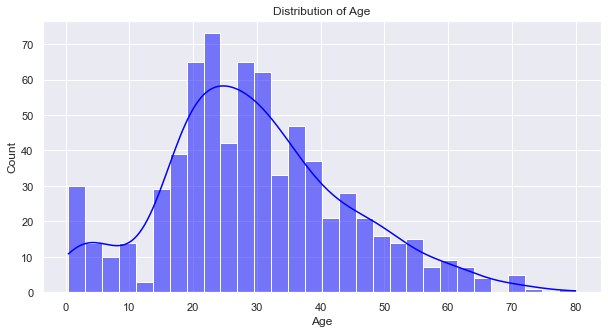

In [98]:
#visualizing the age distribution
plt.figure(figsize=(10, 5))
sns.histplot(data["Age"], bins=30, kde=True, color="blue")
plt.title("Distribution of Age")

In [99]:
#get the mean and median of the age
age_mean = data.Age.mean()
age_median = data.Age.median()
print("Mean age: ", age_mean)
print("Median age: ", age_median)

Mean age:  29.64209269662921
Median age:  28.0


don't see much difference let's use median, incase the outliers becomes extensive it can affect mean 

In [100]:
#impute missing data in age with the median
data["Age"].fillna(age_median, inplace=True)

Text(0.5, 1.0, 'Distribution of Age')

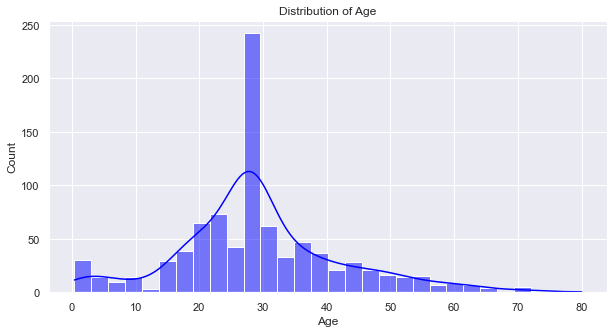

In [101]:
#visualizing the age distribution
plt.figure(figsize=(10, 5))
sns.histplot(data["Age"], bins=30, kde=True, color="blue")
plt.title("Distribution of Age")

imputation induced extremes , need to normalize

<AxesSubplot:title={'center':'Visualizing Missing Values'}>

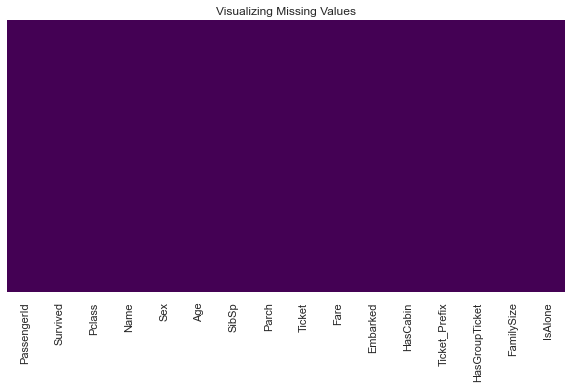

In [102]:
#viaualizing the missing values
plt.figure(figsize=(10, 5)) 
plt.title("Visualizing Missing Values")
sns.heatmap(data.isnull(), cbar=False, cmap="viridis", yticklabels=False)

Visualising the correlation again

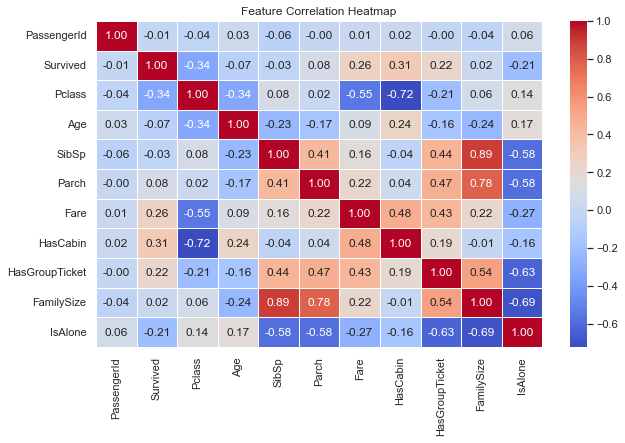

In [103]:
#correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


Need to do encoding , still don't have better correlations

In [104]:
#check the data again
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     889 non-null    int64  
 1   Survived        889 non-null    int64  
 2   Pclass          889 non-null    int64  
 3   Name            889 non-null    object 
 4   Sex             889 non-null    object 
 5   Age             889 non-null    float64
 6   SibSp           889 non-null    int64  
 7   Parch           889 non-null    int64  
 8   Ticket          889 non-null    object 
 9   Fare            889 non-null    float64
 10  Embarked        889 non-null    object 
 11  HasCabin        889 non-null    int32  
 12  Ticket_Prefix   889 non-null    object 
 13  HasGroupTicket  889 non-null    int32  
 14  FamilySize      889 non-null    int64  
 15  IsAlone         889 non-null    int32  
dtypes: float64(2), int32(3), int64(6), object(5)
memory usage: 107.7+ KB


Name is not useful at all can drop

In [105]:
#drop name column
data.drop(["Name"], axis=1, inplace=True)


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     889 non-null    int64  
 1   Survived        889 non-null    int64  
 2   Pclass          889 non-null    int64  
 3   Sex             889 non-null    object 
 4   Age             889 non-null    float64
 5   SibSp           889 non-null    int64  
 6   Parch           889 non-null    int64  
 7   Ticket          889 non-null    object 
 8   Fare            889 non-null    float64
 9   Embarked        889 non-null    object 
 10  HasCabin        889 non-null    int32  
 11  Ticket_Prefix   889 non-null    object 
 12  HasGroupTicket  889 non-null    int32  
 13  FamilySize      889 non-null    int64  
 14  IsAlone         889 non-null    int32  
dtypes: float64(2), int32(3), int64(6), object(4)
memory usage: 100.7+ KB


In [107]:
data.Age.mean()

29.315151856017994

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>,
        <AxesSubplot:title={'center':'HasCabin'}>,
        <AxesSubplot:title={'center':'HasGroupTicket'}>],
       [<AxesSubplot:title={'center':'FamilySize'}>,
        <AxesSubplot:title={'center':'IsAlone'}>, <AxesSubplot:>]],
      dtype=object)

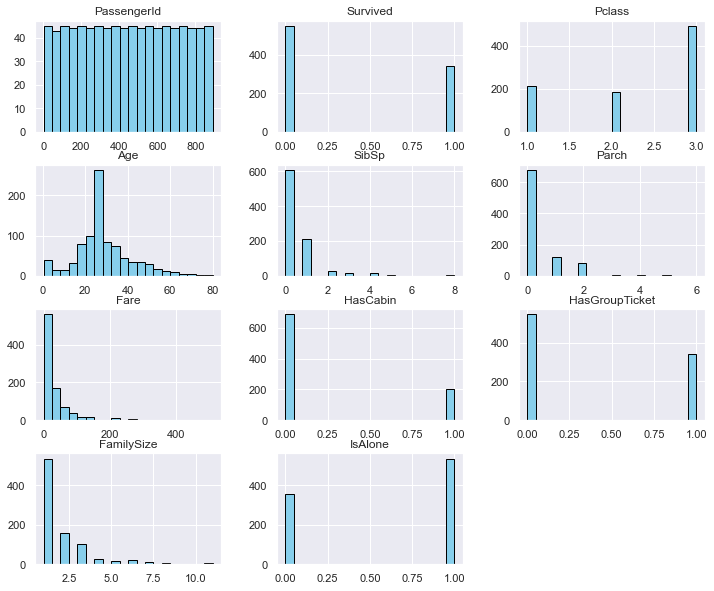

In [108]:
data.hist(figsize=(12, 10), bins=20, color="skyblue", edgecolor="black", linewidth=1.0)

# Data encoding for categorical data

In [109]:
data.dtypes

PassengerId         int64
Survived            int64
Pclass              int64
Sex                object
Age               float64
SibSp               int64
Parch               int64
Ticket             object
Fare              float64
Embarked           object
HasCabin            int32
Ticket_Prefix      object
HasGroupTicket      int32
FamilySize          int64
IsAlone             int32
dtype: object

In [110]:
#encode sex column with label encoding 0 - Male 1 - female
data["Sex"] = data["Sex"].map({"male": 0, "female": 1})


In [111]:
#what other categorical columns do we have
data.select_dtypes(include="object").columns

Index(['Ticket', 'Embarked', 'Ticket_Prefix'], dtype='object')

Ticket is also not needed, got the feature created

In [112]:
#drop ticket column
data.drop(["Ticket"], axis=1, inplace=True)

# OHE for ticket prefix

In [113]:
#one hot encoding the ticket prefix column
data = pd.get_dummies(data, columns=["Ticket_Prefix"], drop_first=True)

In [114]:
#one hot encoding the embarked column
data = pd.get_dummies(data, columns=["Embarked"], drop_first=True)

In [115]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,HasCabin,HasGroupTicket,FamilySize,IsAlone,Ticket_Prefix_C.A.,Ticket_Prefix_None,Ticket_Prefix_Other,Ticket_Prefix_PC,Ticket_Prefix_STON/O,Embarked_Q,Embarked_S
0,1,0,3,0,22.0,1,0,7.2500,0,0,2,0,0,0,0,0,0,0,1
1,2,1,1,1,38.0,1,0,71.2833,1,0,2,0,0,0,0,1,0,0,0
2,3,1,3,1,26.0,0,0,7.9250,0,0,1,1,0,0,1,0,0,0,1
3,4,1,1,1,35.0,1,0,53.1000,1,1,2,0,0,1,0,0,0,0,1
4,5,0,3,0,35.0,0,0,8.0500,0,0,1,1,0,1,0,0,0,0,1


In [116]:
#data null check
data.isnull().sum()

PassengerId             0
Survived                0
Pclass                  0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Fare                    0
HasCabin                0
HasGroupTicket          0
FamilySize              0
IsAlone                 0
Ticket_Prefix_C.A.      0
Ticket_Prefix_None      0
Ticket_Prefix_Other     0
Ticket_Prefix_PC        0
Ticket_Prefix_STON/O    0
Embarked_Q              0
Embarked_S              0
dtype: int64

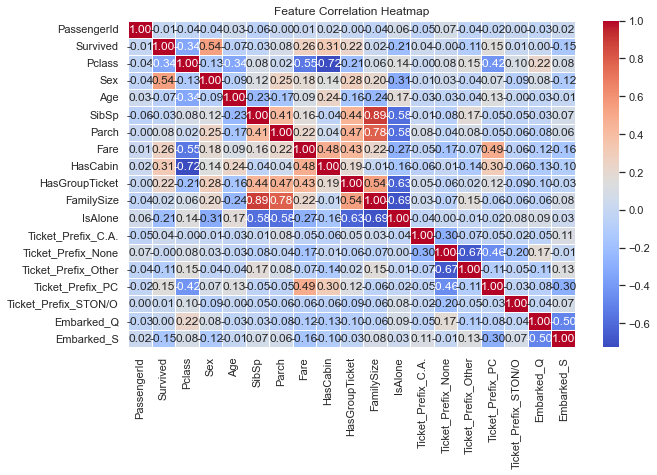

In [117]:
# correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# outlier detection and standardization

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>,
        <AxesSubplot:title={'center':'Sex'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>],
       [<AxesSubplot:title={'center':'HasCabin'}>,
        <AxesSubplot:title={'center':'HasGroupTicket'}>,
        <AxesSubplot:title={'center':'FamilySize'}>,
        <AxesSubplot:title={'center':'IsAlone'}>],
       [<AxesSubplot:title={'center':'Ticket_Prefix_C.A.'}>,
        <AxesSubplot:title={'center':'Ticket_Prefix_None'}>,
        <AxesSubplot:title={'center':'Ticket_Prefix_Other'}>,
        <AxesSubplot:title={'center':'Ticket_Prefix_PC'}>],
       [<AxesSubplot:title={'center':'Ticket_Prefix_STON/O'}>,
        <AxesSubplot:title={'center':'Embarked_Q'}>,
        <AxesSubplot:title={'center':

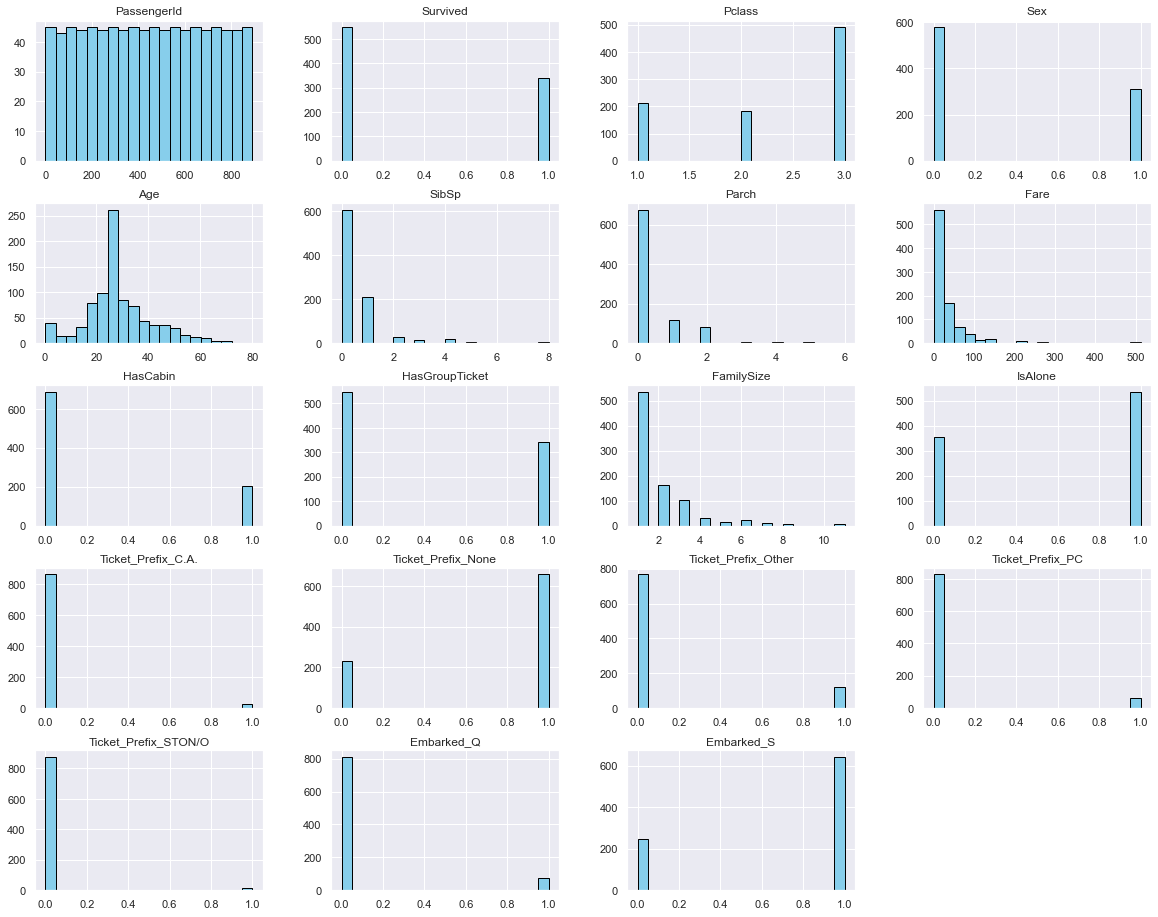

In [118]:
#plotting the data to see the distribution
data.hist(figsize=(20, 16), bins=20, color="skyblue", edgecolor="black", linewidth=1.0)

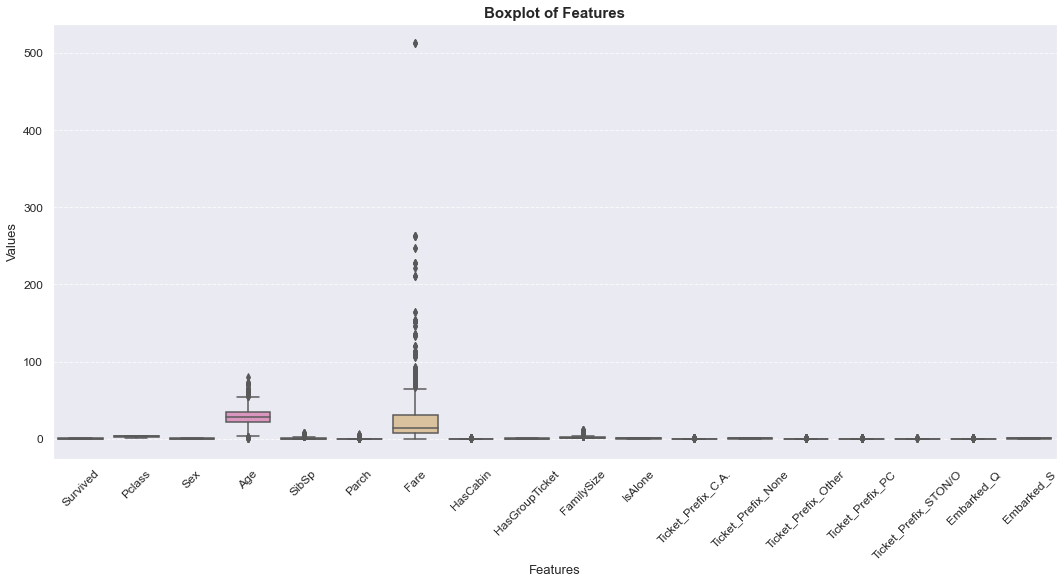

In [119]:
#box plot for the data to check outliers
plt.figure(figsize=(18, 8))
sns.boxplot(data=data.drop(columns=["PassengerId"]), palette="Set2", showfliers=True)  # Use Seaborn for better visuals
plt.xticks(rotation=45, fontsize=12)  # Rotate and enlarge labels
plt.yticks(fontsize=12)
plt.title("Boxplot of Features", fontsize=15, fontweight="bold")
plt.xlabel("Features", fontsize=13)
plt.ylabel("Values", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add subtle grid for readability

plt.show()

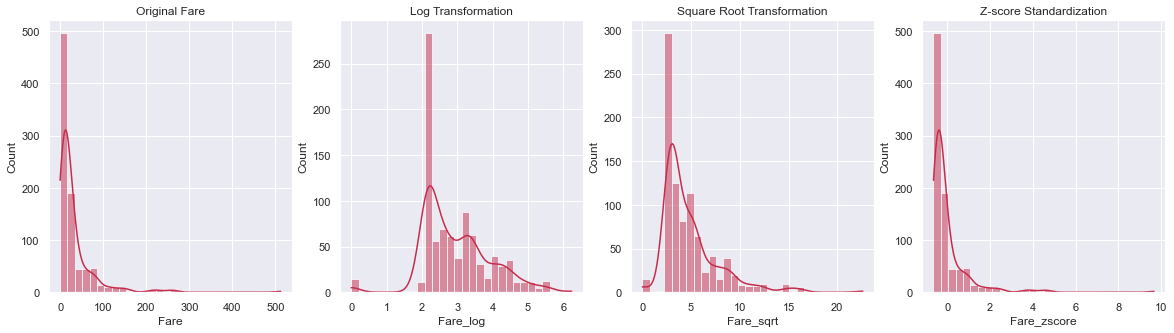

In [120]:
df_transformed = pd.DataFrame()

# Apply transformations and store in df_transformed
df_transformed["Fare_log"] = np.log1p(data["Fare"])  # log(1 + x) to avoid log(0)
df_transformed["Fare_sqrt"] = np.sqrt(data["Fare"])
df_transformed["Fare_zscore"] = (data["Fare"] - data["Fare"].mean()) / data["Fare"].std()

# Plot distributions
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
sns.histplot(data["Fare"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Original Fare")

sns.histplot(df_transformed["Fare_log"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Log Transformation")

sns.histplot(df_transformed["Fare_sqrt"], bins=30, kde=True, ax=axes[2])
axes[2].set_title("Square Root Transformation")

sns.histplot(df_transformed["Fare_zscore"], bins=30, kde=True, ax=axes[3])
axes[3].set_title("Z-score Standardization")

plt.show()

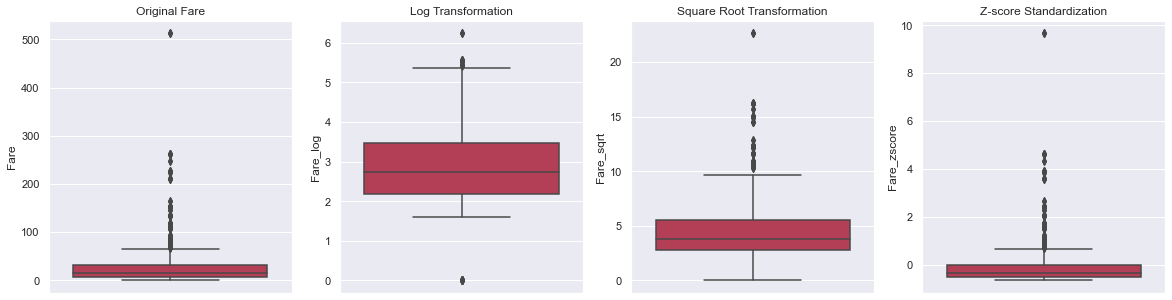

In [121]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot boxplots for original and transformed values
sns.boxplot(y=data["Fare"], ax=axes[0])
axes[0].set_title("Original Fare")

sns.boxplot(y=df_transformed["Fare_log"], ax=axes[1])
axes[1].set_title("Log Transformation")

sns.boxplot(y=df_transformed["Fare_sqrt"], ax=axes[2])
axes[2].set_title("Square Root Transformation")

sns.boxplot(y=df_transformed["Fare_zscore"], ax=axes[3])
axes[3].set_title("Z-score Standardization")

plt.show()


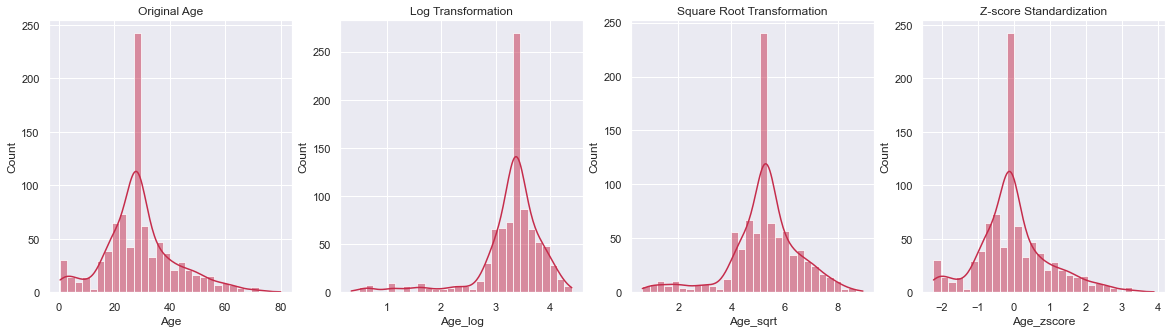

In [122]:
df_transformed["Age_log"] = np.log1p(data["Age"])  # log(1 + x) to avoid log(0)
df_transformed["Age_sqrt"] = np.sqrt(data["Age"])
df_transformed["Age_zscore"] = (data["Age"] - data["Age"].mean()) / data["Age"].std()

# Plot distributions
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
sns.histplot(data["Age"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Original Age")

sns.histplot(df_transformed["Age_log"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Log Transformation")

sns.histplot(df_transformed["Age_sqrt"], bins=30, kde=True, ax=axes[2])
axes[2].set_title("Square Root Transformation")

sns.histplot(df_transformed["Age_zscore"], bins=30, kde=True, ax=axes[3])
axes[3].set_title("Z-score Standardization")

plt.show()

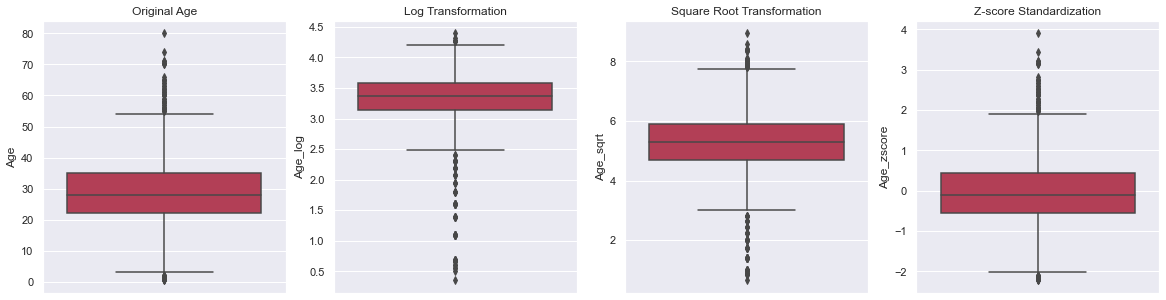

In [123]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot boxplots for original and transformed values
sns.boxplot(y=data["Age"], ax=axes[0])
axes[0].set_title("Original Age")

sns.boxplot(y=df_transformed["Age_log"], ax=axes[1])
axes[1].set_title("Log Transformation")

sns.boxplot(y=df_transformed["Age_sqrt"], ax=axes[2])
axes[2].set_title("Square Root Transformation")

sns.boxplot(y=df_transformed["Age_zscore"], ax=axes[3])
axes[3].set_title("Z-score Standardization")

plt.show()

In [124]:
data["Fare_log"] = df_transformed["Fare_log"]
data["Age_zscore"] = df_transformed["Age_zscore"]

<AxesSubplot:>

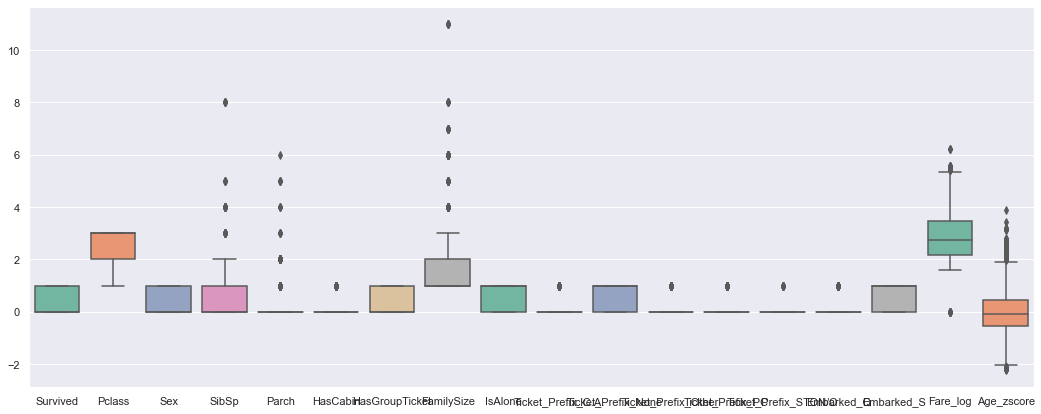

In [125]:
#plotting the box again to compare
plt.figure(figsize=(18, 7))
sns.boxplot(data=data.drop(columns=["PassengerId","Fare","Age"]), palette="Set2", showfliers=True)  # Use Seaborn for better visuals


Text(0.5, 1.0, 'Feature Correlation Heatmap')

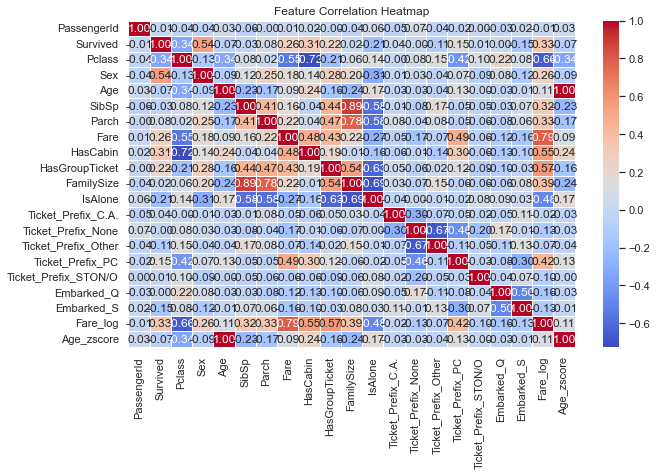

In [126]:
#heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")

Key Correlations:
Pclass (-0.54): Strong negative correlation → Lower-class passengers had lower survival rates.
Sex (0.54): Strong positive correlation → Females had a higher survival rate.
HasCabin (0.48): Moderate positive correlation → Having a cabin (often wealthier passengers) increased survival chances.
Fare_log (0.24): Weak positive correlation → Higher fares (first-class passengers) slightly increased survival probability.
Embarked_C (0.23): Weak positive correlation → Passengers who embarked from Cherbourg had better survival rates.

In [127]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'HasCabin', 'HasGroupTicket', 'FamilySize', 'IsAlone',
       'Ticket_Prefix_C.A.', 'Ticket_Prefix_None', 'Ticket_Prefix_Other',
       'Ticket_Prefix_PC', 'Ticket_Prefix_STON/O', 'Embarked_Q', 'Embarked_S',
       'Fare_log', 'Age_zscore'],
      dtype='object')

In [128]:
#drop old age, old fare columns, rename the age_Zscore to age and fare_log to fare
data.drop(["Age", "Fare"], axis=1, inplace=True)
data.rename(columns={"Age_zscore": "Age", "Fare_log": "Fare"}, inplace=True)

In [129]:
#save the data so far
data.to_csv("cleaned_data_with_outlier_reduction.csv", index=False)

Text(0.5, 1.0, 'Feature Correlation Heatmap')

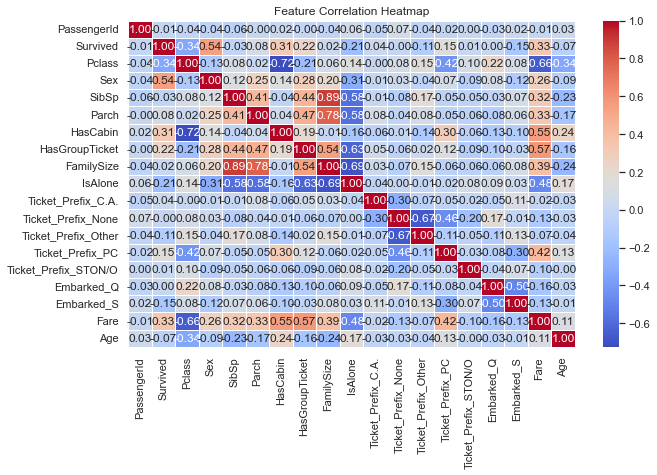

In [130]:
#heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")

# Data splits 
## 70% training , 10% validation , 20% test

In [131]:
final_data=pd.read_csv("cleaned_data_with_outlier_reduction.csv")
final_data.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,HasCabin,HasGroupTicket,FamilySize,IsAlone,Ticket_Prefix_C.A.,Ticket_Prefix_None,Ticket_Prefix_Other,Ticket_Prefix_PC,Ticket_Prefix_STON/O,Embarked_Q,Embarked_S,Fare,Age
0,1,0,3,0,1,0,0,0,2,0,0,0,0,0,0,0,1,2.110213,-0.563357
1,2,1,1,1,1,0,1,0,2,0,0,0,0,1,0,0,0,4.280593,0.668840
2,3,1,3,1,0,0,0,0,1,1,0,0,1,0,0,0,1,2.188856,-0.255308
3,4,1,1,1,1,0,1,1,2,0,0,1,0,0,0,0,1,3.990834,0.437803
4,5,0,3,0,0,0,0,0,1,1,0,1,0,0,0,0,1,2.202765,0.437803


In [139]:
X = final_data.drop(["Survived"], axis=1)
Y = final_data["Survived"]

In [140]:
X.shape, Y.shape

((889, 18), (889,))

In [141]:
#xtrain ytrain and features and target for training
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

In [142]:
#splitting the temp 30% into test and validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [143]:
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [144]:
#save final data files 
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)